<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor_limit128_GradCam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import skimage.transform

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [6]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
    
        

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', 'EPOCH {} '.format(epoch))
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [11]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

In [13]:
device

device(type='cpu')

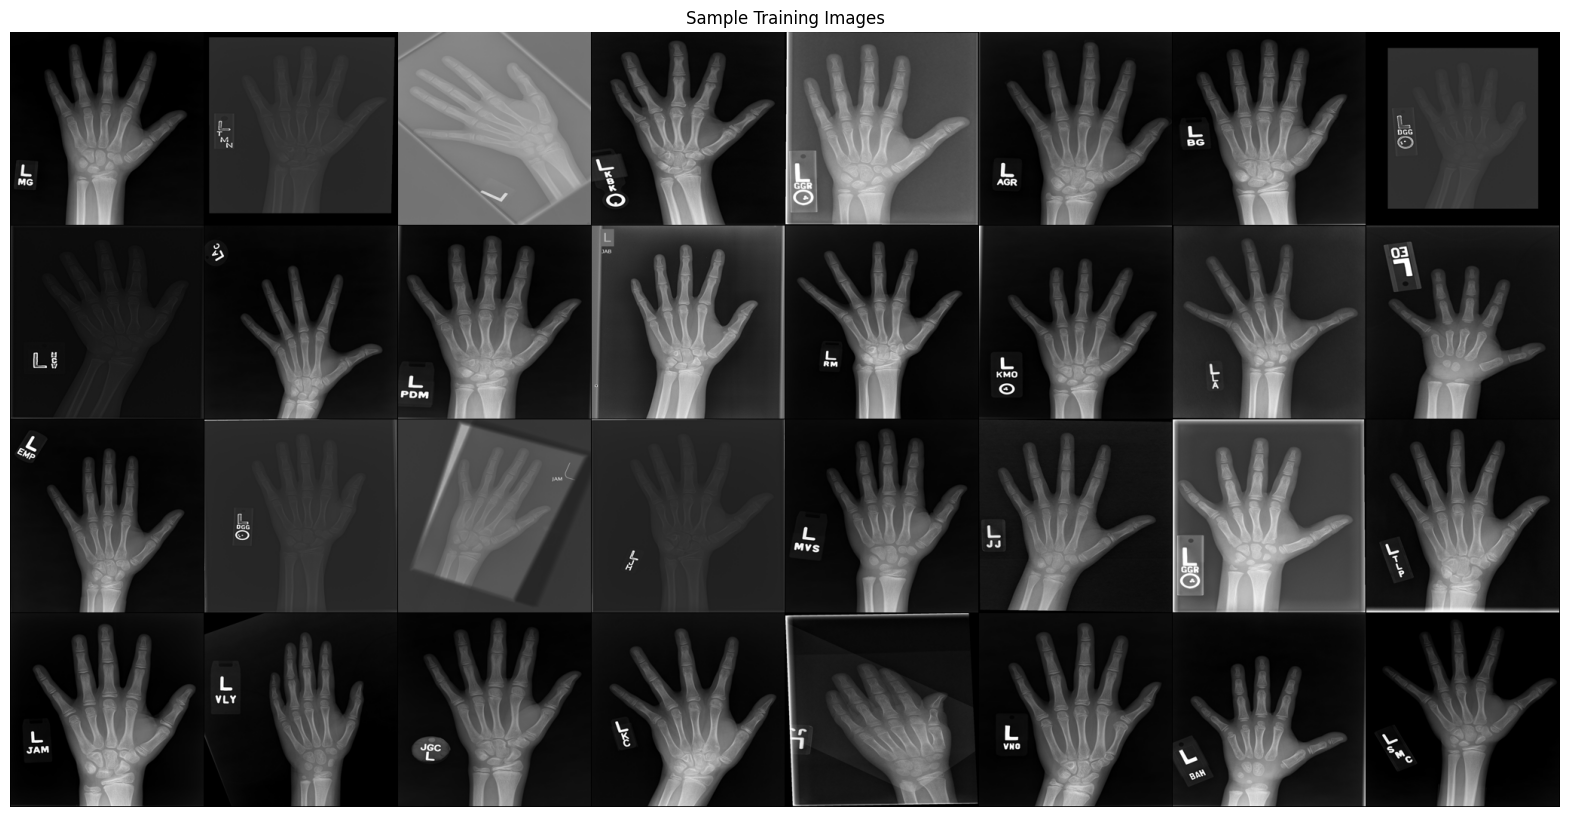

In [14]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [15]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [16]:
train_losses = []
val_losses = []
for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model3_070423.pth')


 EPOCH 0 

 Train set: Average loss: 0.6254


 EPOCH 0 

 Validation set: Average loss: 0.5699


 EPOCH 1 

 Train set: Average loss: 0.5065


 EPOCH 1 

 Validation set: Average loss: 0.4644


 EPOCH 2 

 Train set: Average loss: 0.4513


 EPOCH 2 

 Validation set: Average loss: 0.4086


 EPOCH 3 

 Train set: Average loss: 0.4507


 EPOCH 3 

 Validation set: Average loss: 0.4088


 EPOCH 4 

 Train set: Average loss: 0.3804


 EPOCH 4 

 Validation set: Average loss: 0.3622


 EPOCH 5 

 Train set: Average loss: 0.3575


 EPOCH 5 

 Validation set: Average loss: 0.3517


 EPOCH 6 

 Train set: Average loss: 0.3614


 EPOCH 6 

 Validation set: Average loss: 0.3644


 EPOCH 7 

 Train set: Average loss: 0.3522


 EPOCH 7 

 Validation set: Average loss: 0.3597


 EPOCH 8 

 Train set: Average loss: 0.3719


 EPOCH 8 

 Validation set: Average loss: 0.3901

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.

 EPOCH 9 

 Train set: Average loss: 0.2633


 EPOCH 9 

 Valida

In [17]:
checkpoint = torch.load('model3_070423.pth')
checkpoint

{'epoch': 20,
 'train_loss': [0.6253810809300473,
  0.5064734600442972,
  0.4512726891867382,
  0.4507450855043647,
  0.3804220421604987,
  0.3574842458743886,
  0.3614313066220114,
  0.35216511915388765,
  0.3719469624967272,
  0.2633026049705179,
  0.26583604451081944,
  0.24314804521413513,
  0.23745751724925365,
  0.2239758440652526,
  0.2173733359314601,
  0.2114030952403985,
  0.2030413803226354,
  0.20462945369186122,
  0.190394019032161,
  0.18386871660964613],
 'val_loss': [0.5698811319014921,
  0.46435980659406784,
  0.4086399510655513,
  0.40877878494607567,
  0.36221817492045993,
  0.351726915913043,
  0.36437431740769005,
  0.3597038264943126,
  0.390061379963765,
  0.3085183473746061,
  0.3156313862529458,
  0.30688572190395125,
  0.3081606102310873,
  0.30607994207664546,
  0.3021288583883173,
  0.3052567908814022,
  0.30423024252397185,
  0.30916255355213884,
  0.3052015057969707,
  0.30456568918999977],
 'state_dict': OrderedDict([('conv1.weight',
               tensor

In [18]:
model.load_state_dict(checkpoint['state_dict'])
#model

<All keys matched successfully>

In [19]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [20]:
epoch = checkpoint['epoch']
epoch

20

In [21]:
train_loss = checkpoint['train_loss']
train_loss

[0.6253810809300473,
 0.5064734600442972,
 0.4512726891867382,
 0.4507450855043647,
 0.3804220421604987,
 0.3574842458743886,
 0.3614313066220114,
 0.35216511915388765,
 0.3719469624967272,
 0.2633026049705179,
 0.26583604451081944,
 0.24314804521413513,
 0.23745751724925365,
 0.2239758440652526,
 0.2173733359314601,
 0.2114030952403985,
 0.2030413803226354,
 0.20462945369186122,
 0.190394019032161,
 0.18386871660964613]

In [22]:
val_loss = checkpoint['val_loss']
val_loss

[0.5698811319014921,
 0.46435980659406784,
 0.4086399510655513,
 0.40877878494607567,
 0.36221817492045993,
 0.351726915913043,
 0.36437431740769005,
 0.3597038264943126,
 0.390061379963765,
 0.3085183473746061,
 0.3156313862529458,
 0.30688572190395125,
 0.3081606102310873,
 0.30607994207664546,
 0.3021288583883173,
 0.3052567908814022,
 0.30423024252397185,
 0.30916255355213884,
 0.3052015057969707,
 0.30456568918999977]

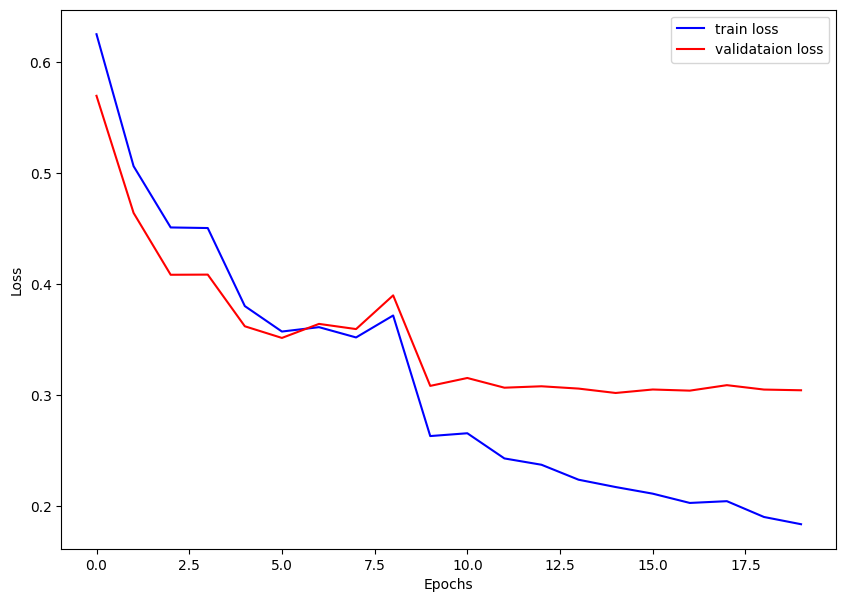

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#grad-cam

In [24]:
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = model
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [25]:
layer = model.conv5  # replace with your model's last convolutional layer
layer

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))

In [26]:
input1 = transform(Image.open(dataset_path('boneage_training_dataset/1377.png')).resize((256,256))).double()  # replace with your input
input1

tensor([[[0.9451, 0.9412, 0.7765,  ..., 0.2745, 0.2784, 0.2824],
         [0.9451, 0.9451, 0.7843,  ..., 0.2706, 0.2706, 0.2784],
         [0.9451, 0.9451, 0.7882,  ..., 0.2667, 0.2706, 0.2745],
         ...,
         [0.8784, 0.8824, 0.8745,  ..., 0.1765, 0.1804, 0.1804],
         [0.8824, 0.8824, 0.8863,  ..., 0.1843, 0.1843, 0.1843],
         [0.8863, 0.8745, 0.8824,  ..., 0.1922, 0.1882, 0.1882]]],
       dtype=torch.float64)

In [27]:
np.shape(input1)

torch.Size([1, 256, 256])

In [28]:
m1 = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m1

tensor([1.], dtype=torch.float64)

In [29]:
input1 = input1.resize(1,1,256,256)
input1

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[[[0.9451, 0.9412, 0.7765,  ..., 0.2745, 0.2784, 0.2824],
          [0.9451, 0.9451, 0.7843,  ..., 0.2706, 0.2706, 0.2784],
          [0.9451, 0.9451, 0.7882,  ..., 0.2667, 0.2706, 0.2745],
          ...,
          [0.8784, 0.8824, 0.8745,  ..., 0.1765, 0.1804, 0.1804],
          [0.8824, 0.8824, 0.8863,  ..., 0.1843, 0.1843, 0.1843],
          [0.8863, 0.8745, 0.8824,  ..., 0.1922, 0.1882, 0.1882]]]],
       dtype=torch.float64)

In [30]:
m1 = m1.resize(1,1)
m1

tensor([[1.]], dtype=torch.float64)

In [31]:
output1 = model(input1, m1)
output1

tensor([[1.3335]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [32]:
features = []
def get_features_hook(model, input1, output1):
    features.append(output1)

hook_handle1 = model.conv5.register_forward_hook(get_features_hook)
output1 = model(input1,m1)
hook_handle1.remove()

feature_maps1 = features[0]
gradients1 = model.conv5.weight.grad

In [33]:
weights1 = torch.mean(gradients1, axis=(2, 3))
cam1 = torch.zeros(feature_maps1.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights1[0]):
    cam1 += w * feature_maps1[0, i, :, :]
cam1 = torch.nn.functional.relu(cam1)
cam1 = cam1.detach().numpy()

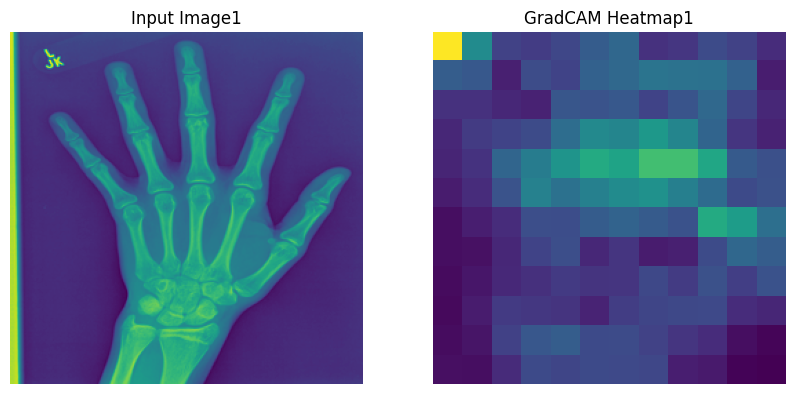

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input1.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image1')
ax[1].imshow(cam1)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap1')
plt.show()

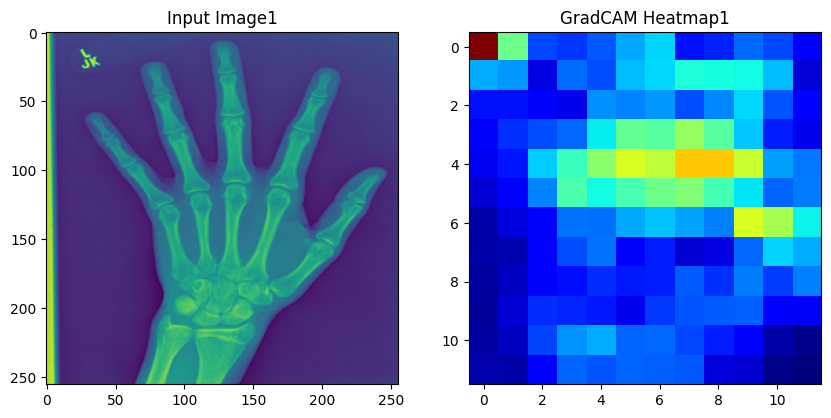

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input1.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image1')
ax[1].imshow(cam1, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap1')
plt.show()

In [36]:
input1.shape

torch.Size([1, 1, 256, 256])

In [37]:
cam1.shape

(12, 12)

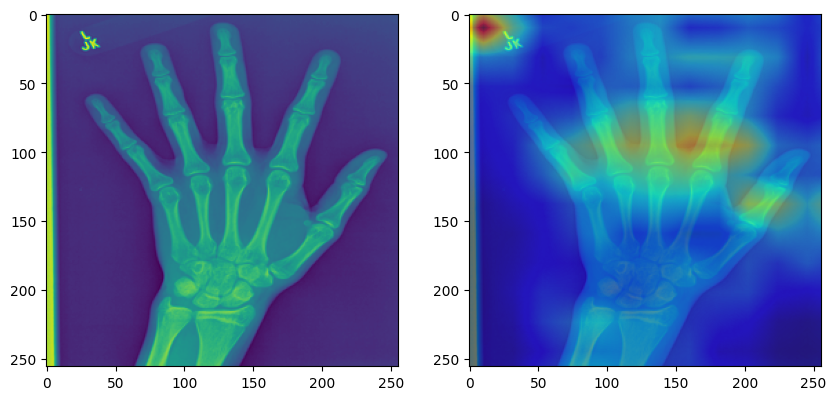

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input1.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input1.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam1, (input1.shape[2],input1.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

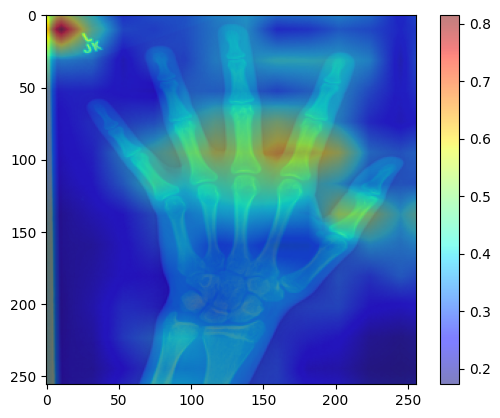

In [39]:
plt.imshow(input1.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam1, (input1.shape[2],input1.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

In [40]:
input2 = transform(Image.open(dataset_path('boneage_training_dataset/13305.png')).resize((256,256))).double()  # replace with your input
input2

tensor([[[0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
         [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
         [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0235],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.1059, 0.1059, 0.1059],
         [0.2196, 0.2157, 0.2196,  ..., 0.2157, 0.2157, 0.2196],
         [0.3961, 0.3922, 0.3922,  ..., 0.4196, 0.4235, 0.4196]]],
       dtype=torch.float64)

In [41]:
np.shape(input2)

torch.Size([1, 256, 256])

In [42]:
#input = input[None,:,:,:]
np.shape(input2)

torch.Size([1, 256, 256])

In [43]:
m2 = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m2

tensor([1.], dtype=torch.float64)

In [44]:
input2 = input2.resize(1,1,256,256)
input2

tensor([[[[0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
          [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
          [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0235],
          ...,
          [0.1294, 0.1255, 0.1255,  ..., 0.1059, 0.1059, 0.1059],
          [0.2196, 0.2157, 0.2196,  ..., 0.2157, 0.2157, 0.2196],
          [0.3961, 0.3922, 0.3922,  ..., 0.4196, 0.4235, 0.4196]]]],
       dtype=torch.float64)

In [45]:
m2 = m2.resize(1,1)
m2

tensor([[1.]], dtype=torch.float64)

In [46]:
output2 = model(input2, m2)
output2

tensor([[2.2460]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [47]:
features = []
def get_features_hook(model, input2, output2):
    features.append(output2)

hook_handle2 = model.conv5.register_forward_hook(get_features_hook)
output2 = model(input2,m2)
hook_handle2.remove()

feature_maps2 = features[0]
gradients2 = model.conv5.weight.grad

In [48]:
weights2 = torch.mean(gradients2, axis=(2, 3))
cam2 = torch.zeros(feature_maps2.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights2[0]):
    cam2 += w * feature_maps2[0, i, :, :]
cam2 = torch.nn.functional.relu(cam2)
cam2 = cam2.detach().numpy()

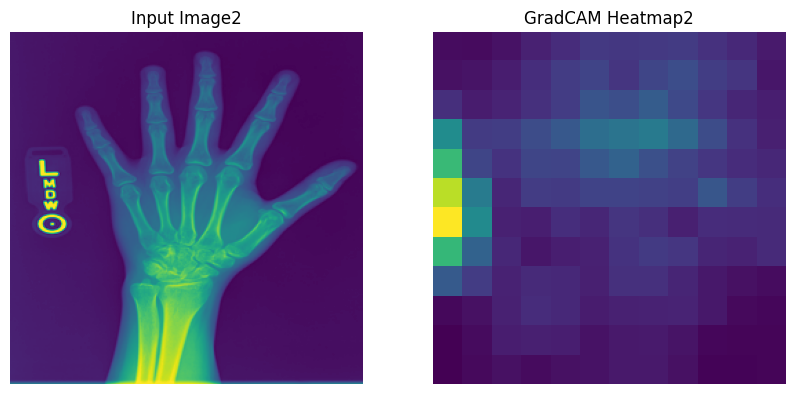

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input2.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image2')
ax[1].imshow(cam2)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap2')
plt.show()

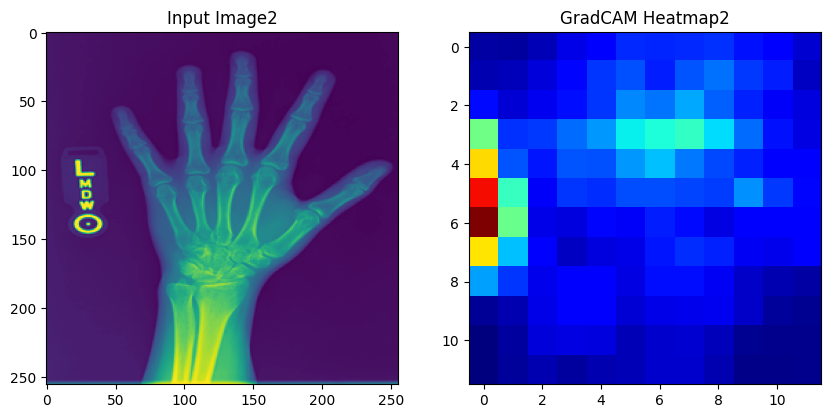

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input2.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image2')
ax[1].imshow(cam2, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap2')
plt.show()

In [51]:
input2.shape

torch.Size([1, 1, 256, 256])

In [52]:
cam2.shape

(12, 12)

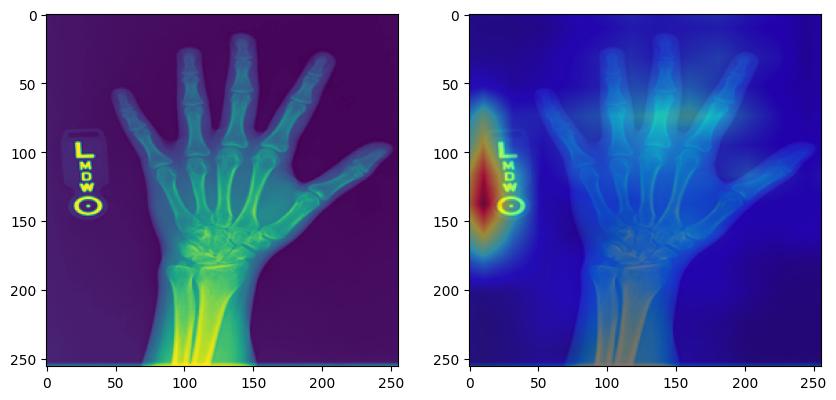

In [53]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input2.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input2.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam2, (input2.shape[2],input2.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

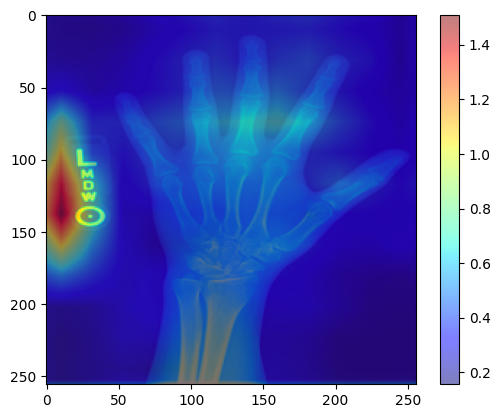

In [54]:
plt.imshow(input2.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam2, (input2.shape[2],input2.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

In [55]:
input3 = transform(Image.open(dataset_path('boneage_training_dataset/12930.png')).resize((256,256))).double()  # replace with your input
input3

tensor([[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0471, 0.0510],
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         ...,
         [0.0824, 0.0824, 0.0784,  ..., 0.0941, 0.0902, 0.0941],
         [0.0784, 0.0784, 0.0784,  ..., 0.0863, 0.0863, 0.0863],
         [0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980]]],
       dtype=torch.float64)

In [56]:
np.shape(input3)

torch.Size([1, 256, 256])

In [57]:
#input = input[None,:,:,:]
np.shape(input3)

torch.Size([1, 256, 256])

In [58]:
m3 = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m3

tensor([1.], dtype=torch.float64)

In [59]:
input3 = input3.resize(1,1,256,256)
input3

tensor([[[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0471, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
          [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0824, 0.0824, 0.0784,  ..., 0.0941, 0.0902, 0.0941],
          [0.0784, 0.0784, 0.0784,  ..., 0.0863, 0.0863, 0.0863],
          [0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980]]]],
       dtype=torch.float64)

In [60]:
m3 = m3.resize(1,1)
m3

tensor([[1.]], dtype=torch.float64)

In [61]:
output3 = model(input3, m3)
output3

tensor([[0.2605]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [62]:
features = []
def get_features_hook(model, input3, output3):
    features.append(output3)

hook_handle3 = model.conv5.register_forward_hook(get_features_hook)
output3 = model(input3,m3)
hook_handle3.remove()

feature_maps3= features[0]
gradients3 = model.conv5.weight.grad

In [63]:
weights3 = torch.mean(gradients3, axis=(2, 3))
cam3 = torch.zeros(feature_maps3.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights3[0]):
    cam3 += w * feature_maps3[0, i, :, :]
cam3 = torch.nn.functional.relu(cam3)
cam3 = cam3.detach().numpy()

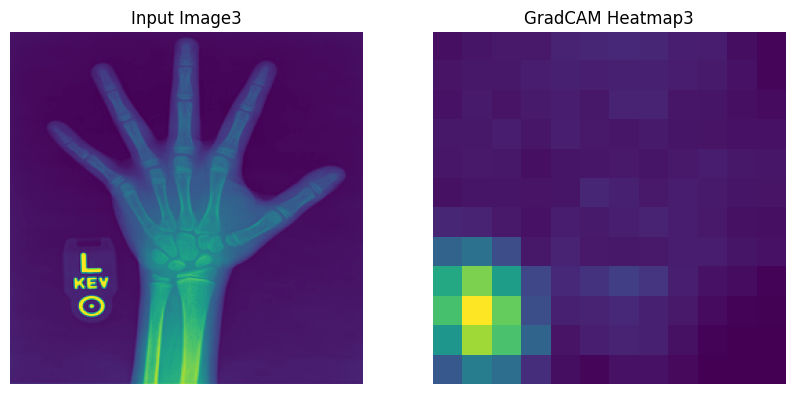

In [64]:
ig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input3.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image3')
ax[1].imshow(cam3)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap3')
plt.show()

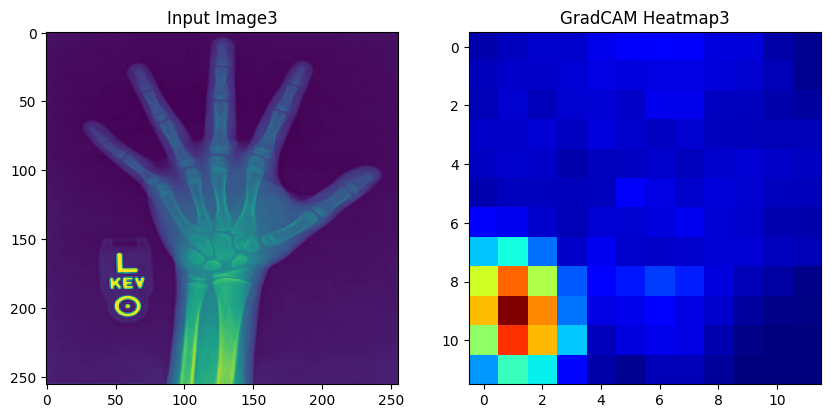

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input3.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image3')
ax[1].imshow(cam3, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap3')
plt.show()


In [66]:
input3.shape

torch.Size([1, 1, 256, 256])

In [67]:
cam3.shape

(12, 12)

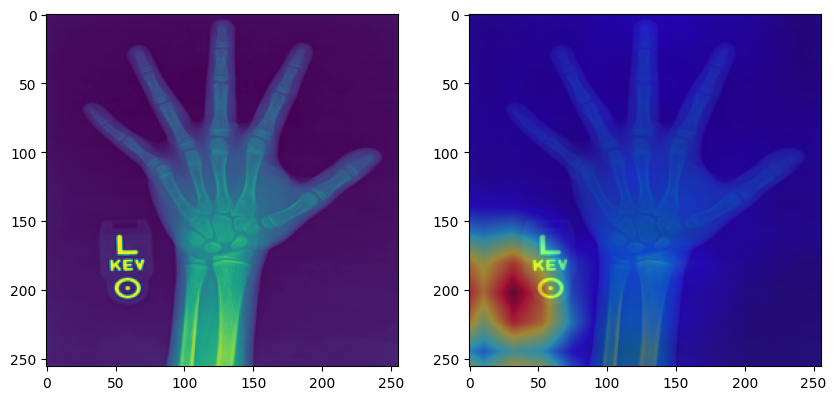

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input3.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input3.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam3, (input3.shape[2],input3.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

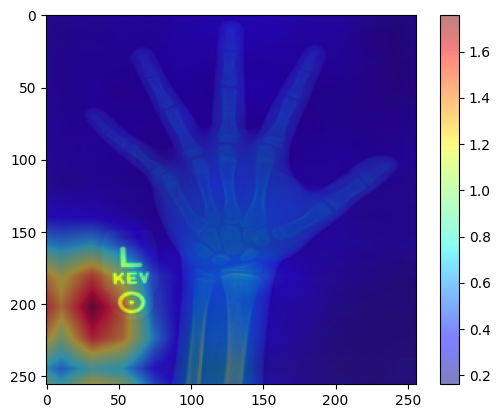

In [69]:
plt.imshow(input3.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam3, (input3.shape[2],input3.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

In [70]:
input4 = transform(Image.open(dataset_path('boneage_training_dataset/12496.png')).resize((256,256))).double()  # replace with your input
input4

tensor([[[0.2902, 0.2078, 0.2118,  ..., 0.4314, 0.4667, 0.5294],
         [0.2039, 0.1294, 0.1333,  ..., 0.1804, 0.2235, 0.2980],
         [0.2000, 0.1216, 0.1255,  ..., 0.0902, 0.1451, 0.2392],
         ...,
         [0.2118, 0.2039, 0.2039,  ..., 0.2000, 0.3098, 0.4627],
         [0.4118, 0.4039, 0.3961,  ..., 0.2000, 0.3098, 0.4627],
         [0.7333, 0.7216, 0.7137,  ..., 0.2353, 0.3294, 0.4706]]],
       dtype=torch.float64)

In [71]:
np.shape(input4)

torch.Size([1, 256, 256])

In [72]:
#input = input[None,:,:,:]
np.shape(input4)

torch.Size([1, 256, 256])

In [73]:
m4 = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m4

tensor([1.], dtype=torch.float64)

In [74]:
input4 = input4.resize(1,1,256,256)
input4

tensor([[[[0.2902, 0.2078, 0.2118,  ..., 0.4314, 0.4667, 0.5294],
          [0.2039, 0.1294, 0.1333,  ..., 0.1804, 0.2235, 0.2980],
          [0.2000, 0.1216, 0.1255,  ..., 0.0902, 0.1451, 0.2392],
          ...,
          [0.2118, 0.2039, 0.2039,  ..., 0.2000, 0.3098, 0.4627],
          [0.4118, 0.4039, 0.3961,  ..., 0.2000, 0.3098, 0.4627],
          [0.7333, 0.7216, 0.7137,  ..., 0.2353, 0.3294, 0.4706]]]],
       dtype=torch.float64)

In [75]:
m4 = m4.resize(1,1)
m4

tensor([[1.]], dtype=torch.float64)

In [76]:
output4 = model(input4, m4)
output4

tensor([[-0.2495]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [77]:
features = []
def get_features_hook(model, input4, output4):
    features.append(output4)

hook_handle4 = model.conv5.register_forward_hook(get_features_hook)
output4 = model(input4,m4)
hook_handle4.remove()

feature_maps4 = features[0]
gradients4 = model.conv5.weight.grad

In [78]:
weights4 = torch.mean(gradients4, axis=(2, 3))
cam4 = torch.zeros(feature_maps4.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights4[0]):
    cam4 += w * feature_maps4[0, i, :, :]
cam4 = torch.nn.functional.relu(cam4)
cam4 = cam4.detach().numpy()

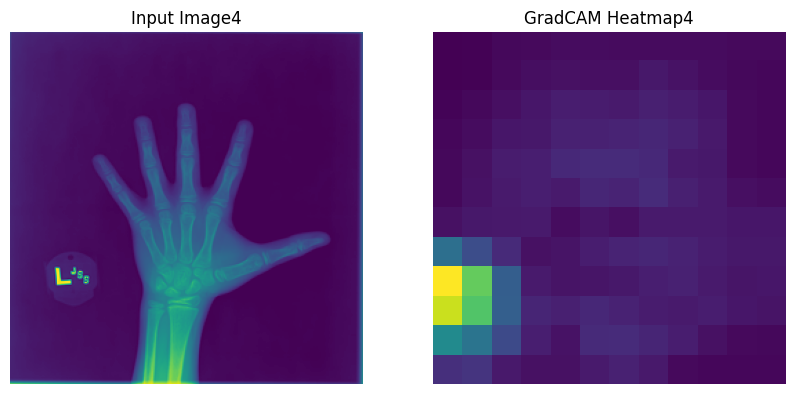

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input4.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image4')
ax[1].imshow(cam4)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap4')
plt.show()

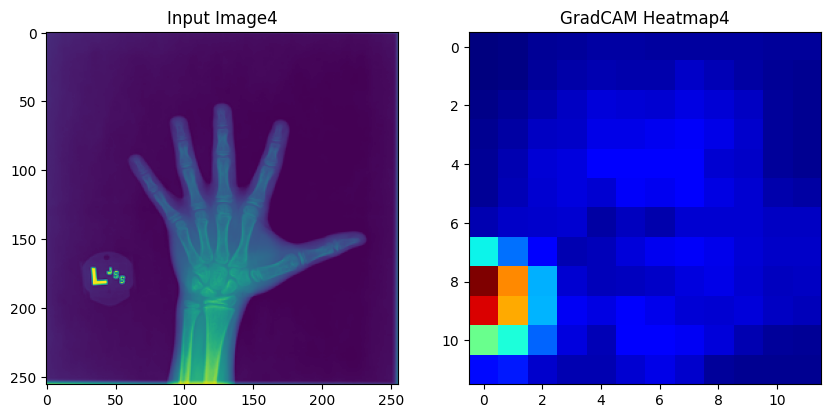

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input4.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image4')
ax[1].imshow(cam4, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap4')
plt.show()

In [81]:
input4.shape

torch.Size([1, 1, 256, 256])

In [82]:
cam4.shape

(12, 12)

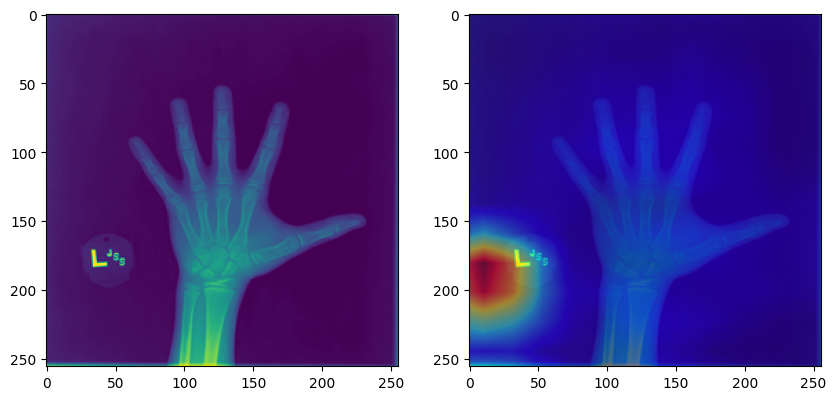

In [83]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input4.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input4.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam4, (input4.shape[2],input4.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

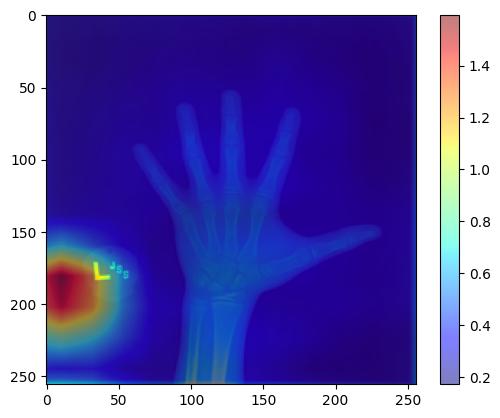

In [84]:
plt.imshow(input4.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam4, (input4.shape[2],input4.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()